# Práctica 3 - Prueba 12

#### Pilar Navarro Ramírez

In [1]:
import pandas as pd

## Preprocesamiento

In [2]:
df_train=pd.read_csv("data/train.csv",na_values=[""])
df_test=pd.read_csv("data/test.csv",na_values=[""])

In [3]:
df_train.columns = [col.lower() for col in df_train]
df_test.columns = [col.lower() for col in df_test]

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

del df_train["id"]
del df_test["id"]

### Tratamos los datos perdidos

In [4]:
from sklearn import impute

In [5]:
del df_train['descuento']
del df_test['descuento']

In [6]:
df_train_replaced=df_train.copy()
imputer=impute.SimpleImputer(strategy="most_frequent")
values = imputer.fit_transform([df_train_replaced.asientos.values])
df_train_replaced.asientos.update(pd.Series(values[0]))

In [7]:
df_train_replaced=df_train_replaced.dropna()
df_train=df_train.dropna()

Separamos el atributo a predecir del resto de atributos en el conjunto de entrenamiento.

In [8]:
cols = [col for col in df_train.columns if col not in ['precio_cat']]    
df_train, df_train_obj= df_train[cols], df_train['precio_cat']
df_train_replaced, df_train_obj_replaced= df_train_replaced[cols], df_train_replaced['precio_cat']

### Nos quedamos sólo con la marca del nombre

In [9]:
nombre=pd.read_csv("data/nombre.csv")
nombre.columns = [col.lower() for col in nombre]

#Función que se queda con la primera palabra de una cadena
def marca(cad):
    return cad.split(' ', 1)[0]
nombre['nombre'] = nombre['nombre'].map(marca)
nombre=nombre.drop_duplicates()
df_train['nombre']=df_train['nombre'].map(marca)
df_train_replaced['nombre']=df_train_replaced['nombre'].map(marca)
df_test['nombre']=df_test['nombre'].map(marca)

## Transformación de variables categóricas a numéricas

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_num=df_train.copy()
df_train_num_rpl=df_train_replaced.copy()
df_test_num=df_test.copy()

for atributo in categorical:
    if atributo=='nombre':
        data=nombre.copy()
    else:
        data=pd.read_csv("data/"+atributo+".csv")
        data.columns = [col.lower() for col in data]
    label = LabelEncoder().fit(data[atributo])
    df_train_num[atributo]=label.transform(df_train[atributo])
    df_train_num_rpl[atributo]=label.transform(df_train_replaced[atributo])
    df_test_num[atributo]=label.transform(df_test[atributo])

In [11]:
df_train_num['nombre'].unique()

array([18, 17, 10,  9,  8,  1, 19, 28,  4, 24, 27, 29, 13,  2,  6, 25, 20,
       21, 22,  7, 23, 16, 30, 14,  5,  3, 15, 12, 11])

### Normalización de los datos

In [12]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cols = [col for col in df_train_orig.columns if col not in ['precio_cat','id','descuento']]  
categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_norm=df_train_num.copy()
df_train_norm_rpl=df_train_num_rpl.copy()
df_test_norm=df_test_num.copy()


for atributo in cols:
    if atributo=='nombre':
        data=nombre.copy()
    else:
        data=pd.read_csv("data/"+atributo+".csv")
        data.columns = [col.lower() for col in data]
    if atributo in categorical:
        label = LabelEncoder().fit(data[atributo])
        data[atributo]=label.transform(data[atributo])
    scaler = MinMaxScaler().fit(data.values)
    train_values=df_train_num[atributo].values.reshape(-1,1)
    df_train_norm[atributo]=scaler.transform(train_values)
    train_values_rpl=df_train_num_rpl[atributo].values.reshape(-1,1)
    df_train_norm_rpl[atributo]=scaler.transform(train_values_rpl)
    test_values=df_test_num[atributo].values.reshape(-1,1)
    df_test_norm[atributo]=scaler.transform(test_values)
    

In [13]:
df_train_norm['nombre'].unique()

array([0.6       , 0.56666667, 0.33333333, 0.3       , 0.26666667,
       0.03333333, 0.63333333, 0.93333333, 0.13333333, 0.8       ,
       0.9       , 0.96666667, 0.43333333, 0.06666667, 0.2       ,
       0.83333333, 0.66666667, 0.7       , 0.73333333, 0.23333333,
       0.76666667, 0.53333333, 1.        , 0.46666667, 0.16666667,
       0.1       , 0.5       , 0.4       , 0.36666667])

In [14]:
df_train_norm.head()

,nombre,ciudad,año,kilometros,combustible,tipo_marchas,mano,consumo,motor_cc,potencia,asientos
0,0.600000,0.5,0.666667,0.012743,0.25,1.0,0.0,0.822844,0.096552,0.808108,0.5
1,0.600000,0.7,0.857143,0.000712,1.00,1.0,0.0,0.675991,0.993103,0.754054,0.5
2,0.566667,0.4,0.857143,0.003974,0.25,1.0,0.0,0.878788,0.075862,0.832432,0.6
3,0.333333,0.3,0.714286,0.008609,1.00,1.0,0.0,0.547786,0.068966,0.843243,0.5
4,0.300000,0.6,0.904762,0.006432,1.00,1.0,0.0,0.564103,0.082759,0.929730,0.5


### Oversampling

In [15]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
smote=BorderlineSMOTE(random_state=10)
df_train_over, df_train_obj_over = smote.fit_resample(df_train_num, df_train_obj)
df_train_over_rpl, df_train_obj_over_rpl = smote.fit_resample(df_train_num_rpl, df_train_obj_replaced)
Counter(df_train_obj_over)

Counter({3: 1825, 2: 1825, 4: 1825, 5: 1825, 1: 1825})

## Aplicación de los algoritmos

In [16]:
import numpy as np

from sklearn.model_selection import cross_val_score

def cross_validation(clf,x,y,mostrar=False):
    scores=cross_val_score(clf,x,y,scoring='accuracy',cv=5)
    accuracy=np.mean(scores)  
    if mostrar:
        print("Accuracy: ", accuracy)
    return accuracy

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf=GradientBoostingClassifier(random_state=10,max_features='auto')
print("Datos normalizados con todos nulos eliminados: ")
print(clf)
cross_validation(clf, df_train_over, df_train_obj_over,True)
print("Datos normalizados con nulos en asientos reemplazados: ")
print(clf)
cross_validation(clf, df_train_over_rpl, df_train_obj_over_rpl,True)

Datos normalizados con todos nulos eliminados: 
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy:  0.8613698630136986
Datos normalizados con nulos en asientos reemplazados: 
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
              

### Configuración de los parámetros

#### Gradient Boosting

In [ ]:
print("Fraction of samples to be used for fitting the individual base learners = 0.8")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.8)
cross_validation(gradient, df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.6")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.6)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.9")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.9)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.7")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.7)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.5")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.5)
cross_validation(gradient,df_train_over, df_train_obj_over,True)

Fraction of samples to be used for fitting the individual base learners = 0.8
Accuracy:  0.8613698630136988
Fraction of samples to be used for fitting the individual base learners = 0.6
Accuracy:  0.8613698630136986
Fraction of samples to be used for fitting the individual base learners = 0.9
Accuracy:  0.8613698630136988
Fraction of samples to be used for fitting the individual base learners = 0.7
Accuracy:  0.8609315068493151
Fraction of samples to be used for fitting the individual base learners = 0.5
Accuracy:  0.8614794520547946


0.8614794520547946

Configurando el parámetro max_depth de cada estimador.

In [17]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
def tune_gradient_boosting(max_value):
    acc=[]
    for i in range(2,max_value):
        gradient=GradientBoostingClassifier(max_depth=i,random_state=10,subsample=0.5)
        print(i)
        acc.append(cross_validation(gradient,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(2,max_value), acc)
    ax.set_title('Gradient Boosting')
    ax.set_xlabel('Max depth')
    ax.set_ylabel('Accuracy')
    plt.show()

2
Accuracy:  0.8122739726027397
3
Accuracy:  0.8561095890410959
4
Accuracy:  0.8781369863013699
5
Accuracy:  0.8920547945205479
6
Accuracy:  0.8980821917808219
7
Accuracy:  0.8997260273972604
8
Accuracy:  0.9035616438356164
9
Accuracy:  0.9064109589041095
10
Accuracy:  0.9059726027397259
11
Accuracy:  0.9066301369863015
12
Accuracy:  0.9060821917808219
13
Accuracy:  0.9032328767123288
14
Accuracy:  0.9046575342465755
15
Accuracy:  0.9024657534246575
16
Accuracy:  0.9032328767123288
17
Accuracy:  0.9007123287671233
18
Accuracy:  0.9002739726027397
19
Accuracy:  0.9006027397260274


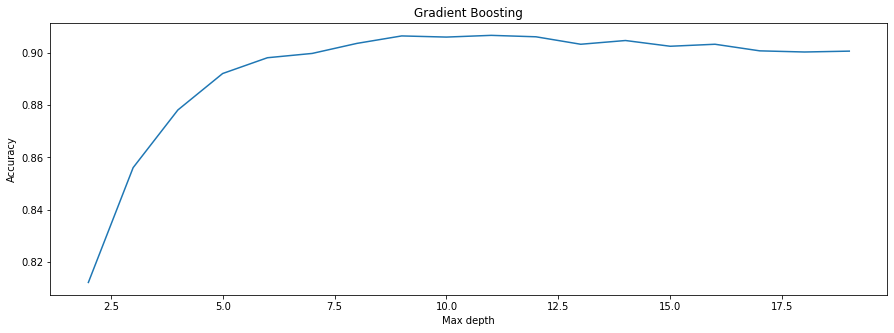

In [18]:
tune_gradient_boosting(20)

Configurando el número de estimadores.

50
Accuracy:  0.8918356164383561
100
Accuracy:  0.9035616438356164
150
Accuracy:  0.9079452054794521
200
Accuracy:  0.9092602739726028
250
Accuracy:  0.9113424657534246
300
Accuracy:  0.9106849315068495
350
Accuracy:  0.9115616438356164
400
Accuracy:  0.9113424657534246
450
Accuracy:  0.9111232876712329


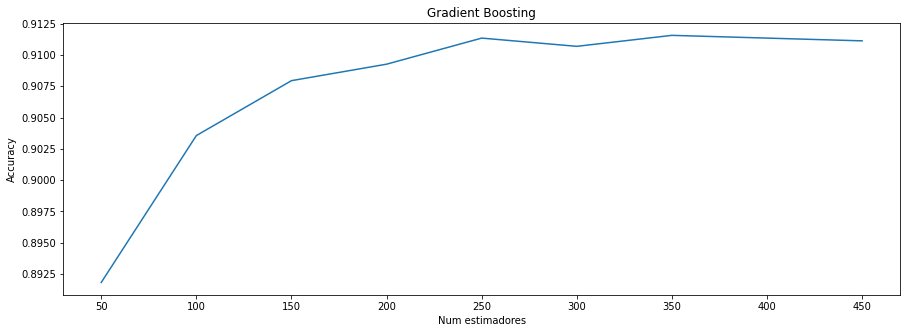

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
def tune_gradient_boosting_2(max_value):
    acc=[]
    for i in range(50,max_value,50):
        gradient=GradientBoostingClassifier(n_estimators=i,max_depth=8,random_state=10,subsample=0.5)
        print(i)
        acc.append(cross_validation(gradient,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(50,max_value,50), acc)
    ax.set_title('Gradient Boosting')
    ax.set_xlabel('Num estimadores')
    ax.set_ylabel('Accuracy')
    plt.show()
tune_gradient_boosting_2(500) 

Configurando el parámetro learning_rate.

In [ ]:
print("Learning rate=0.2")
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.05")
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.05, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.15")
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.15, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.3")
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.3, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.1")
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True) 

Learning rate=0.2
Accuracy:  0.9088219178082191
Learning rate=0.05
Accuracy:  0.9107945205479453
Learning rate=0.15
Accuracy:  0.9102465753424657
Learning rate=0.3
Accuracy:  0.9039999999999999
Learning rate=0.1
Accuracy:  0.9117808219178082


0.9117808219178082

### Aplicación al conjunto de test

#### Entrega 23


In [28]:
gradient=GradientBoostingClassifier(n_estimators=450, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.5,max_depth=8)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
gradient.fit(df_train_over,df_train_obj_over)
pred=gradient.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_23.csv", index=False)

Accuracy:  0.9117808219178082
